# Actor critic methods

Recall that in policy gradient methods, the gradient estimate with to-go reward is given by

$$J(\theta) = \mathbb{E}_{\tau\sim p_{\theta}(\tau)} \bigg[\sum_t\nabla_{\theta}\log \pi_{\theta}(\mathbf{a}_t|\mathbf{s}_t)\bigg(\sum_{t'\geq t} r(\mathbf{s}_{t'}, \mathbf{a}_{t'})\bigg)\bigg]$$

Where the to-go reward serves as an unbiased estimator of the action value function $Q(\mathbf{s}, \mathbf{a})$. To further reduce the variance, we performed baseline subtraction. This gives us our final estimate

$$J(\theta) = \mathbb{E}_{\tau\sim p_{\theta}(\tau)} \bigg[\sum_t\nabla_{\theta}\log \pi_{\theta}(\mathbf{a}_t|\mathbf{s}_t)\bigg(\sum_{t'\geq t} r(\mathbf{s}_{t'}, \mathbf{a}_{t'})-b\bigg)\bigg]$$

Even though we have a formula for the optimal baseline, in practice, it is hard to compute, so other heuristics is typically used. Finding a good baseline is another challenge. However, note that if we choose the baseline $b$ to be the value function $V(\mathbf{s})$, then the gradient estimate can be written as

$$J(\theta) \approx \mathbb{E}_{\tau\sim p_{\theta}(\tau)} \bigg[\sum_t\nabla_{\theta}\log \pi_{\theta}(\mathbf{a}_t|\mathbf{s}_t)(Q(\mathbf{s}_t, \mathbf{a}_t)-V(\mathbf{s}_t))\bigg]$$

Now the log-likelihood is weighted by $A(\mathbf{s}_t, \mathbf{a}_t)=Q(\mathbf{s}_t, \mathbf{a}_t)-V(\mathbf{s}_t)$. We call this term the advantage function, and it has a natrual interpretation: it represents whether the action $\mathbf{a}$ is better or worse than the agent's default action in a given state. If taking the action $\mathbf{a}$ results in postive advantage, then its corresponding action probability would be raised. Conversely, if the advantage is negative, then its action probability would be lowered. <br>

Now the question is how to estimate the advantage function $A(\mathbf{s}_t, \mathbf{a}_t)$. In the actor critic algorithm, we parameterize the value function $V_{\phi}$ with a neural network, and for the action value function $Q$, we have two choices

$$
\begin{align*}
    Q(\mathbf{s}_t, \mathbf{a}_t) &= r(\mathbf{s}_t, \mathbf{a}_t) + \gamma\mathbb{E}_{\pi_{\theta}}\bigg[\sum_{t'\geq t+1} \gamma^{t'}r(\mathbf{s}_{t'}, \mathbf{a}_{t'})\bigg|\;\mathbf{s}_t, \mathbf{a}_t\bigg]\\
    &\approx r(\mathbf{s}_t, \mathbf{a}_t) + \gamma V(\mathbf{s}_{t+1}) \hspace{3mm}\text{or}\\
    &\approx \sum_{t'\geq t} \gamma^{t'}r(\mathbf{s}_{t'}, \mathbf{a}_{t'})
\end{align*}
$$

Both of these choices are valid, but in practice, we choose the former estimate since it has lower variance (see generalized advantage estimation). The advantage function is therefore estimated with 

$$A(\mathbf{s}_t, \mathbf{a}_t) = r(\mathbf{s}_t, \mathbf{a}_t) + \gamma V_{\phi}(\mathbf{s}_{t+1})- V_{\phi}(\mathbf{s}_t)$$

Now that we can compute the advantage function, we can use it to define the policy loss objective  $J(\theta)$. However, we still need to learn the value function $V_{\phi}$. To achieve this, we must first specify the targets for $V_{\phi}$. This can be done using two primary methods: the Monte Carlo approach or the Temporal Difference (TD) approach.

## Monte Carlo value estimation

Recall that we can estimate the value function as 

$$V(\mathbf{s}_t) \approx \sum_{t'\geq t}r(\mathbf{s}_t, \mathbf{a}_t)$$

This suggests that we directly fit $V_{\phi}$ on the data $\{(\mathbf{s}_t, \sum_{t'\geq t}r(\mathbf{s}_t, \mathbf{a}_t)\}$, using the mean square error loss function.

$$L(\phi) = \sum_{t} (V_{\phi}(\mathbf{s}_t) - \sum_{t'\geq t}r(\mathbf{s}_t, \mathbf{a}_t))^2$$

## Temporal difference value estimation

To use Monte Carlo methods, we need to wait until the entire trajectory has been sampled before calculating the returns. Alternatively, we can use the Temporal Difference (TD) approach, which allows us to update the value function incrementally based on estimates from previous steps

$$V(\mathbf{s}_t) \approx r(\mathbf{s}_t, \mathbf{a}_t) + \gamma V(\mathbf{s}_{t+1})$$

In other words, we fit $V_{\phi}$ on the data on the data $\{(\mathbf{s}_t, r(\mathbf{s}_t, \mathbf{a}_t) + \gamma V_{\phi}(\mathbf{s}_{t+1}))\}$, and like before, using the mean square error loss function.

$$L(\phi) = \sum_{t} (r(\mathbf{s}_t, \mathbf{a}_t) + \gamma V(\mathbf{s}_{t+1})- V(\mathbf{s}_t) )^2$$

## Actor critic algorithm

The psuedocode of the full actor critic algorithm is presented below

```{prf:algorithm} Actor critic algorithm
:label: my-algorithm

**Inputs** Differentiable policy $\pi_{\theta}$, value function $V_{\phi}$, learning rate $\alpha$, number of episodes $N$, batch size $K$

1. While episode $n<N$:
	1. Generate $K$ trajectories following policy $\pi_{\theta}(\mathbf{a}|\mathbf{s})$
	2. Fit value function $V_{\phi}$ using either Monte-Carlo or Temporal difference methods
       
       $$
       \begin{align*}
       &L(\phi) = \sum_{t} (V_{\phi}(\mathbf{s}_t) - \sum_{t'\geq t}r(\mathbf{s}_t, \mathbf{a}_t))^2\hspace{4mm}\text{or}\hspace{4mm}(MC)\\
       &L(\phi) = \sum_{t} (r(\mathbf{s}_t, \mathbf{a}_t) + \gamma V(\mathbf{s}_{t+1})- V(\mathbf{s}_t) )^2\hspace{4mm}(TD)\\
       &\phi\leftarrow \phi - \alpha \nabla_{\phi} L(\phi)
       \end{align*}$$
       
    3. Update policy 
    
       $$
       \begin{align*}
       &J(\theta) = \frac{1}{K}\sum_{i=1}^K \sum_t\nabla_{\theta}\log \pi_{\theta}(\mathbf{a}_{i, t}|\mathbf{s}_{i. t})(r(\mathbf{s}_{i, t}, \mathbf{a}_{i, t}) + \gamma V_{\phi}(\mathbf{s}_{i, t+1})- V_{\phi}(\mathbf{s}_{i, t}))\\
       &\theta\leftarrow \theta + \alpha \nabla_{\theta}J(\theta)
       \end{align*}
       $$
```

We now implement both types of actor critic algorithm and test its performance on Cartpole environment. 

## Actor critic approximation

### Policy and value function implementation

In [ ]:
!pip -q install pybullet
!pip -q install stable-baselines3[extra]
!pip -q install pyvirtualdisplay
!apt-get install -y xvfb

import gym
import pybullet_envs
import matplotlib.pyplot as plt
import pyvirtualdisplay
import imageio
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils as utils
from torch.utils.data import Dataset, DataLoader
from utils import *

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class Policy(nn.Module):
    """
    Implementation of policy class
    """
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super(Policy, self).__init__()
        self.net = SimpleNeuralNetwork(in_dim=state_dim, hidden_dim=hidden_dim, out_dim=action_dim, final_layer="Softmax")

    def forward(self, state):
        return self.net(state)

    def select_action(self, state):
        state = torch.tensor(state).float().to(DEVICE)
        action_dist = self.net(state)
        action_dist = torch.distributions.Categorical(probs=action_dist)
        action = action_dist.sample()
        return action

    def log_prob(self, state, action):
        state = torch.tensor(state).float().to(DEVICE)
        action_dist = self.net(state)
        action_dist = torch.distributions.Categorical(probs=action_dist)
        log_prob = action_dist.log_prob(action)
        return log_prob

class ValueNetwork(nn.Module):
    """
    Implementation of value function
    """
    def __init__(self, state_dim, hidden_dim=128, action_dim=1):
        super(ValueNetwork, self).__init__()
        self.net = SimpleNeuralNetwork(in_dim=state_dim, hidden_dim=hidden_dim, out_dim=action_dim, final_layer=None)

    def forward(self, state):
        return self.net(state).squeeze(-1)

### Actor critic with Monte Carlo implementation

In [ ]:
class ActorCriticMCAgent(Agent):
    """
    Implementation of actor critic agent that uses Monte Carlo estimate for value function
    """
    def __init__(self, env, policy, value, lr=1e-4, device="cpu"):
        self.env = env
        self.policy = policy.to(device)
        self.value = value.to(device)
        self.device = device
        self.policy_optimizer = optim.Adam(self.policy.parameters() , lr=lr)
        self.value_optimizer = optim.Adam(self.value.parameters(), lr=lr)

    def learn_episode(self, *param):
        batch_size, max_steps, gamma = param
        value_loss, policy_loss, reward = 0.0, 0.0, 0.0
        for _ in range(batch_size):
            states, actions, rewards, dones = self.sample_trajectory(env=self.env, gamma=gamma, max_steps=max_steps)
            rewards_cum = torch.cumsum(rewards.flip(dims=[0]), dim=0).flip(dims=[0])
            value_loss += nn.MSELoss()(self.value(states[:-1]), rewards_cum) / batch_size
            log_probs = self.policy.get_action_log_prob(states[:-1], actions)
            advantage = rewards + gamma * (1 - dones) * self.value(states[1:]) - self.value(states[:-1])
            policy_loss += (-log_probs * advantage.detach()).sum() / batch_size
            reward += rewards.sum().item() / batch_size
        self.value_optimizer.zero_grad()
        value_loss.backward()
        self.value_optimizer.step()
        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        self.policy_optimizer.step()
        loss = policy_loss.item() + value_loss.item()
        return loss, reward

For both the policy and value function, we used a simple neural network with $128$ hidden units. The agent is trained for $3500$ episodes using Adam optimizer with learning rate $10^{-3}$. We tested the performance of agents using different batch size, as shown in the figure below. 

In [ ]:
env = gym.make('CartPoleBulletEnv-v1')
policy = Policy(4, 2)
value = ValueNetwork(4, 128)
agent = ActorCriticMCAgent(env, policy, value, lr=1e-3)
history = agent.learn(3500, batch_size=4, print_every=50)

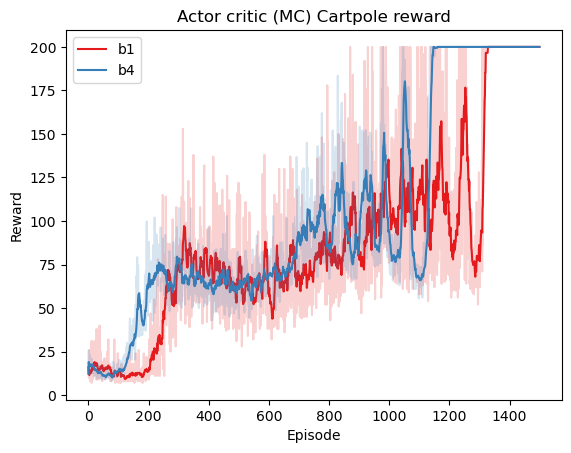

In [5]:
import numpy as np
import matplotlib.pyplot as plt

rewards = [np.load("/Users/raymondtsao/Desktop/ReinforcementLearningNotes/notes/PolicyGradient/ac_mc/b1_reward.npy"),
           np.load("/Users/raymondtsao/Desktop/ReinforcementLearningNotes/notes/PolicyGradient/ac_mc/b4_reward.npy"),]

names = ["b1", "b4"]
colors = np.load("colors.npy")

def smooth(rewards, l):
    smoothed_rewards = []
    for i in range(len(rewards)):
        start_index = max(0, i - l + 1)
        smoothed_rewards.append(np.mean(rewards[start_index:i + 1]))
    return smoothed_rewards

for i, reward in enumerate(rewards):
    plt.plot(reward, c=colors[i], alpha=0.2)
    plt.plot(smooth(reward, 10), c=colors[i], label=names[i])
plt.title("Actor critic (MC) Cartpole reward")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.show()

### Actor critic with TD implementation

In [ ]:
class ActorCriticTDAgent(Agent):
    """
    Implementation of actor critic agent that uses temporal difference estimate for value function
    """
    def __init__(self, env, policy, value, lr=1e-4, device="cpu"):
        self.env = env
        self.policy = policy.to(device)
        self.value = value.to(device)
        self.device = device
        self.policy_optimizer = optim.Adam(self.policy.parameters() , lr=lr)
        self.value_optimizer = optim.Adam(self.value.parameters(), lr=lr)

    def learn_episode(self, *param):
        batch_size, max_steps, gamma = param
        value_loss, policy_loss, reward = 0.0, 0.0, 0.0
        for _ in range(batch_size):
            states, actions, rewards, dones = self.sample_trajectory(env=self.env, gamma=gamma, max_steps=max_steps)
            with torch.no_grad():
                target = rewards + gamma * (1 - dones) * self.value(states[1:])
            value_loss += nn.MSELoss()(self.value(states[:-1]), target) / batch_size
            log_probs = self.policy.get_action_log_prob(states[:-1], actions)
            advantage = rewards + gamma * (1 - dones) * self.value(states[1:]) - self.value(states[:-1])
            policy_loss += (-log_probs * advantage.detach()).sum() / batch_size
            reward += rewards.sum().item() / batch_size
        self.value_optimizer.zero_grad()
        value_loss.backward()
        self.value_optimizer.step()
        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        self.policy_optimizer.step()
        loss = policy_loss.item() + value_loss.item()
        return loss, reward

We trained an agent using temporal difference estimates with the same architecture as before. Notably, only the agent with a batch size of $4$ was able to train effectively. This is because the temporal difference method, being biased, requires slightly more samples to obtain a sufficiently accurate estimate of the value function. The temporal difference estimate, however, has much lower variance. This can be seen in reward plot. The agent using the Monte Carlo estimate exhibited much larger variations in episode return.

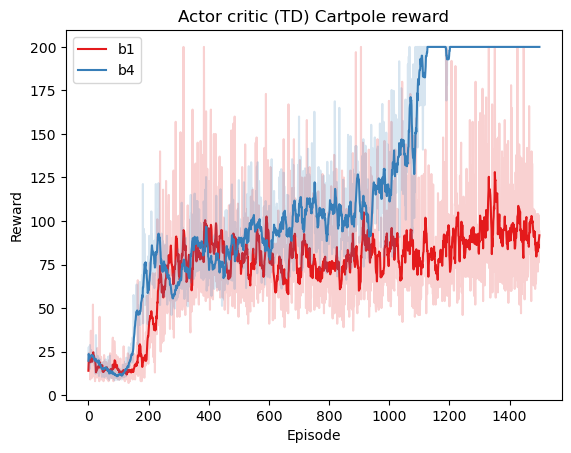

In [4]:
rewards = [np.load("/Users/raymondtsao/Desktop/ReinforcementLearningNotes/notes/PolicyGradient/ac_td/b1_reward.npy"),
           np.load("/Users/raymondtsao/Desktop/ReinforcementLearningNotes/notes/PolicyGradient/ac_td/b4_reward.npy"),]

names = ["b1", "b4"]
colors = np.load("colors.npy")

def smooth(rewards, l):
    smoothed_rewards = []
    for i in range(len(rewards)):
        start_index = max(0, i - l + 1)
        smoothed_rewards.append(np.mean(rewards[start_index:i + 1]))
    return smoothed_rewards

for i, reward in enumerate(rewards):
    plt.plot(reward, c=colors[i], alpha=0.2)
    plt.plot(smooth(reward, 10), c=colors[i], label=names[i])
plt.title("Actor critic (TD) Cartpole reward")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.show()

<span style="font-size:20px;"><strong>Citations</strong></span>

[1] https://lilianweng.github.io/posts/2018-04-08-policy-gradient/ <br>
[2] https://rail.eecs.berkeley.edu/deeprlcourse/